In [1]:
%matplotlib inline


Classifying Names with a Character-Level RNN
*********************************************
**Author**: `Sean Robertson <https://github.com/spro/practical-pytorch>`_

We will be building and training a basic character-level RNN to classify
words. A character-level RNN reads words as a series of characters -
outputting a prediction and "hidden state" at each step, feeding its
previous hidden state into each next step. We take the final prediction
to be the output, i.e. which class the word belongs to.

Specifically, we'll train on a few thousand surnames from 18 languages
of origin, and predict which language a name is from based on the
spelling:

::

    $ python predict.py Hinton
    (-0.47) Scottish
    (-1.52) English
    (-3.57) Irish

    $ python predict.py Schmidhuber
    (-0.19) German
    (-2.48) Czech
    (-2.68) Dutch


**Recommended Reading:**

I assume you have at least installed PyTorch, know Python, and
understand Tensors:

-  http://pytorch.org/ For installation instructions
-  :doc:`/beginner/deep_learning_60min_blitz` to get started with PyTorch in general
-  :doc:`/beginner/pytorch_with_examples` for a wide and deep overview
-  :doc:`/beginner/former_torchies_tutorial` if you are former Lua Torch user

It would also be useful to know about RNNs and how they work:

-  `The Unreasonable Effectiveness of Recurrent Neural
   Networks <http://karpathy.github.io/2015/05/21/rnn-effectiveness/>`__
   shows a bunch of real life examples
-  `Understanding LSTM
   Networks <http://colah.github.io/posts/2015-08-Understanding-LSTMs/>`__
   is about LSTMs specifically but also informative about RNNs in
   general

Preparing the Data
==================

.. Note::
   Download the data from
   `here <https://download.pytorch.org/tutorial/data.zip>`_
   and extract it to the current directory.

Included in the ``data/names`` directory are 18 text files named as
"[Language].txt". Each file contains a bunch of names, one name per
line, mostly romanized (but we still need to convert from Unicode to
ASCII).

We'll end up with a dictionary of lists of names per language,
``{language: [names ...]}``. The generic variables "category" and "line"
(for language and name in our case) are used for later extensibility.



###  18개의 언어에서 수 천개의 성을 훈련시키고 , 이름이 어떤 언어인지 예측함


data / names 디렉토리에는 "[Language] .txt"라는 18 개의 텍스트 파일이 포함되어있고,  각 파일에는 한 줄에 하나의 이름이 포함되어 있으며 대부분 로마자로 표시되어 있습니다 (단, 유니 코드에서 ASCII로 변환해야 함).

{language : [names ...]}라는 언어 별 사전 목록이 만들어집니다. 일반 변수 "category"와 "line"(이 경우 언어와 이름 용)은 이후의 확장 성을 위해 사용됩니다


In [6]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427

#유니코드를 변환
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )


print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language


category_lines = {}
all_categories = []



['data/names/German.txt', 'data/names/Irish.txt', 'data/names/Japanese.txt', 'data/names/Polish.txt', 'data/names/Spanish.txt', 'data/names/English.txt', 'data/names/Korean.txt', 'data/names/Russian.txt', 'data/names/Portuguese.txt', 'data/names/Vietnamese.txt', 'data/names/Greek.txt', 'data/names/Dutch.txt', 'data/names/Czech.txt', 'data/names/Italian.txt', 'data/names/Chinese.txt', 'data/names/French.txt', 'data/names/Scottish.txt', 'data/names/Arabic.txt']
Slusarski


In [7]:
# Read a file and split into lines

#파일 읽고 나누기
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = filename.split('/')[-1].split('.')[0] # 파일 나누고
    all_categories.append(category) #모드 
    lines = readLines(filename) 
    category_lines[category] = lines

n_categories = len(all_categories)

In [8]:
print(n_categories)

18


In [9]:

#나라이름들

all_categories 

['German',
 'Irish',
 'Japanese',
 'Polish',
 'Spanish',
 'English',
 'Korean',
 'Russian',
 'Portuguese',
 'Vietnamese',
 'Greek',
 'Dutch',
 'Czech',
 'Italian',
 'Chinese',
 'French',
 'Scottish',
 'Arabic']

In [10]:
#split?의 예


a="asdasd/asda"

a.split('/')[-1] # / 를 기준으로 나눈다. 

'asda'

In [7]:


# 파일네임과, 카테고리 ?

for filename in findFiles('data/names/*.txt'):
    category = filename.split('/')[-1].split('.')[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines
    print(filename)
    print(category)
    
    

data/names/German.txt
German
data/names/Irish.txt
Irish
data/names/Japanese.txt
Japanese
data/names/Polish.txt
Polish
data/names/Spanish.txt
Spanish
data/names/English.txt
English
data/names/Korean.txt
Korean
data/names/Russian.txt
Russian
data/names/Portuguese.txt
Portuguese
data/names/Vietnamese.txt
Vietnamese
data/names/Greek.txt
Greek
data/names/Dutch.txt
Dutch
data/names/Czech.txt
Czech
data/names/Italian.txt
Italian
data/names/Chinese.txt
Chinese
data/names/French.txt
French
data/names/Scottish.txt
Scottish
data/names/Arabic.txt
Arabic


Now we have ``category_lines``, a dictionary mapping each category
(language) to a list of lines (names). We also kept track of
``all_categories`` (just a list of languages) and ``n_categories`` for
later reference.




In [11]:
category_lines["Korean"] #언어와 이름을 

['Ahn',
 'Baik',
 'Bang',
 'Byon',
 'Cha',
 'Chang',
 'Chi',
 'Chin',
 'Cho',
 'Choe',
 'Choi',
 'Chong',
 'Chou',
 'Chu',
 'Chun',
 'Chung',
 'Chweh',
 'Gil',
 'Gu',
 'Gwang ',
 'Ha',
 'Han',
 'Ho',
 'Hong',
 'Hung',
 'Hwang',
 'Hyun ',
 'Jang',
 'Jeon',
 'Jeong',
 'Jo',
 'Jon',
 'Jong',
 'Jung ',
 'Kang',
 'Kim',
 'Ko',
 'Koo',
 'Ku',
 'Kwak',
 'Kwang ',
 'Lee',
 'Li',
 'Lim ',
 'Ma',
 'Mo',
 'Moon',
 'Nam',
 'Ngai',
 'Noh',
 'Oh ',
 'Pae',
 'Pak',
 'Park ',
 'Ra',
 'Rhee',
 'Rheem',
 'Ri',
 'Rim',
 'Ron',
 'Ryom',
 'Ryoo',
 'Ryu',
 'San',
 'Seo',
 'Seok',
 'Shim',
 'Shin',
 'Shon',
 'Si',
 'Sin',
 'So',
 'Son',
 'Song',
 'Sook',
 'Suh',
 'Suk',
 'Sun',
 'Sung',
 'Tsai ',
 'Wang',
 'Woo',
 'Yang',
 'Yeo',
 'Yeon',
 'Yi',
 'Yim',
 'Yoo',
 'Yoon',
 'You',
 'Youj',
 'Youn',
 'Yu',
 'Yun']

In [12]:
#이탈리안 다섯번쟤까지 출력

print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


Turning Names into Tensors
--------------------------

이름을 텐서로 튜닝하기 


Now that we have all the names organized, we need to turn them into
Tensors to make any use of them.

To represent a single letter, we use a "one-hot vector" of size
``<1 x n_letters>``. A one-hot vector is filled with 0s except for a 1
at index of the current letter, e.g. ``"b" = <0 1 0 0 0 ...>``.

To make a word we join a bunch of those into a 2D matrix
``<line_length x 1 x n_letters>``.

That extra 1 dimension is because PyTorch assumes everything is in
batches - we're just using a batch size of 1 here.

단일 문자를 나타 내기 위해 크기가 "원 핫 벡터 (one-hot vector)"를 사용합니다.
``<1 x n_letters>``. 1 핫 벡터는 1을 제외하고 0으로 채워진다.
현재의 문자의 인덱스, 예를 들면. `` "b"= <0 1 0 0 0 ...>``.

단어를 만들기 위해 우리는 그 무리를 2D 행렬에 결합시킵니다.
``<line_length x 1 x n_letters>``.

그 여분의 1 차원은 PyTorch가 모든 것이 있다고 가정하기 때문입니다.
일괄 처리 - 여기서 일괄 처리 크기 1을 사용하고 있습니다.



In [22]:
import torch #파이토치 임포트 

# Find letter index from all_letters, e.g. "a" = 0

# all_letters에서 letter의 순서를 찾기. 예를 들어 "a" = 0

def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print("example ~~~ letter TO TENSOR~~~")
print(letterToTensor('J'))

print(letterToTensor('-'))

print("exmape~~~ line~ to~~ ten~~~")

print(lineToTensor('Jones').size()) ## 


print(lineToTensor('a').size())



example ~~~ letter TO TENSOR~~~


Columns 0 to 12 
    0     0     0     0     0     0     0     0     0     0     0     0     0

Columns 13 to 25 
    0     0     0     0     0     0     0     0     0     0     0     0     0

Columns 26 to 38 
    0     0     0     0     0     0     0     0     0     1     0     0     0

Columns 39 to 51 
    0     0     0     0     0     0     0     0     0     0     0     0     0

Columns 52 to 56 
    0     0     0     0     0
[torch.FloatTensor of size 1x57]



Columns 0 to 12 
    0     0     0     0     0     0     0     0     0     0     0     0     0

Columns 13 to 25 
    0     0     0     0     0     0     0     0     0     0     0     0     0

Columns 26 to 38 
    0     0     0     0     0     0     0     0     0     0     0     0     0

Columns 39 to 51 
    0     0     0     0     0     0     0     0     0     0     0     0     0

Columns 52 to 56 
    0     0     0     0     1
[torch.FloatTensor of size 1x57]

exmape~~~ line~ to~~ ten~~

In [11]:
#example of tensor zero~~~


torch.zeros(1,100)




Columns 0 to 12 
    0     0     0     0     0     0     0     0     0     0     0     0     0

Columns 13 to 25 
    0     0     0     0     0     0     0     0     0     0     0     0     0

Columns 26 to 38 
    0     0     0     0     0     0     0     0     0     0     0     0     0

Columns 39 to 51 
    0     0     0     0     0     0     0     0     0     0     0     0     0

Columns 52 to 64 
    0     0     0     0     0     0     0     0     0     0     0     0     0

Columns 65 to 77 
    0     0     0     0     0     0     0     0     0     0     0     0     0

Columns 78 to 90 
    0     0     0     0     0     0     0     0     0     0     0     0     0

Columns 91 to 99 
    0     0     0     0     0     0     0     0     0
[torch.FloatTensor of size 1x100]

Creating the Network
====================
네트워크 생성
==================


Autograd를 사용하기 전에 Torch에서 recurrent neural network 만드는 작업에는 여러 타임 스텝에서 레이어의 매개 변수를 복제하는 작업이 포함되었습니다. 그래프에 자체에서 hidden state와  gradients를 헨들할수 있는 레이어를 가지고 있다.  그라디언트를 가지며 이제 그래프 자체에서 완전히 처리됩니다. 즉, feed-forward layers.처럼 RNN을 매우 "순수한"방식으로 구현할 수 있습니다.








In [23]:
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax()
    
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return Variable(torch.zeros(1, self.hidden_size))

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [24]:
#nn.Linear???

print(nn.Linear(5,4))
"""
http://pytorch.org/docs/master/nn.html



Linear layers
class torch.nn.Linear(in_features, out_features, bias=True)[source]
Applies a linear transformation to the incoming data: y=Ax+by=Ax+b



"""


Linear (5 -> 4)


'\nhttp://pytorch.org/docs/master/nn.html\n\n\n\nLinear layers\nclass torch.nn.Linear(in_features, out_features, bias=True)[source]\nApplies a linear transformation to the incoming data: y=Ax+by=Ax+b\n\n\n\n'

In [14]:
# torch cat?





이 네트워크를 실행하려면 인풋(이 경우에는
현재 letter에 대한 Tensor)와 이전 히든 스테이트
(우리가 처음에 0으로 초기화)를 통과해야 합니다. 

그리고 결과(각 언어의 확률 )와 다음 히든스테이트 (우리가 다음스텝을 위해 킵 해야 할것).


파이토치 모듈은 텐서에서 바로 작용되지 않고 변수에서 작동되는 것을 기억하세요.





In [25]:
input = Variable(letterToTensor('A'))#알파벳을 텐서로
hidden = Variable(torch.zeros(1, n_hidden)) #히든스테잇

output, next_hidden = rnn(input, hidden) #아웃풋하고, 다음 히든스테잇

In [16]:
print(input)
print(hidden)

Variable containing:

Columns 0 to 12 
    0     0     0     0     0     0     0     0     0     0     0     0     0

Columns 13 to 25 
    0     0     0     0     0     0     0     0     0     0     0     0     0

Columns 26 to 38 
    1     0     0     0     0     0     0     0     0     0     0     0     0

Columns 39 to 51 
    0     0     0     0     0     0     0     0     0     0     0     0     0

Columns 52 to 56 
    0     0     0     0     0
[torch.FloatTensor of size 1x57]

Variable containing:

Columns 0 to 12 
    0     0     0     0     0     0     0     0     0     0     0     0     0

Columns 13 to 25 
    0     0     0     0     0     0     0     0     0     0     0     0     0

Columns 26 to 38 
    0     0     0     0     0     0     0     0     0     0     0     0     0

Columns 39 to 51 
    0     0     0     0     0     0     0     0     0     0     0     0     0

Columns 52 to 64 
    0     0     0     0     0     0     0     0     0     0     0     0     0

Col



효율성을 위해 각 스텝마다 새로운텐서를 만들지 않습니다.

그래서

``letterToTensor` 대신에``lineToTensor``를 사용할 것입니다.



In [27]:
input = Variable(lineToTensor('Albert')) #라인 투 텐서
hidden = Variable(torch.zeros(1, n_hidden)) #히든 스테이트 
output, next_hidden = rnn(input[0], hidden)
print(output)

Variable containing:

Columns 0 to 9 
-2.8913 -2.8391 -2.8880 -2.9434 -2.9547 -2.9481 -2.8669 -2.8157 -2.8749 -2.9858

Columns 10 to 17 
-2.8966 -2.8742 -2.9436 -2.8406 -2.9837 -2.8022 -2.8056 -2.9013
[torch.FloatTensor of size 1x18]




아웃풋은 각 아이템들이 그 카테고리의 라이클리후드(higher is more likely)  ``<1 x n_categories>`` 형태의  텐서이다.





Training
========
Preparing for Training
----------------------

Before going into training we should make a few helper functions. The
first is to interpret the output of the network, which we know to be a
likelihood of each category. We can use ``Tensor.topk`` to get the index
of the greatest value:

트레이닝을 시작하기 전에 몇 가지 헬퍼함수를 만들어야합니다. 
첫번째는 각 카테고리의 라이클리후드가 얼마나 되는 것인지에 대한 네트워크의 아웃풋을 설명하는 것 입니다. 

우리는``Tensor.topk``를 사용하여  가장 큰 벨류의 인덱스를 구할수 있습니다


In [29]:
def categoryFromOutput(output):
    top_n, top_i = output.data.topk(1) # Tensor out of Variable with .data
    category_i = top_i[0][0]
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('French', 15)


We will also want a quick way to get a training example (a name and its
language):
좀 더 빨리 훈련 예를 구하려면 



In [40]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = Variable(torch.LongTensor([all_categories.index(category)]))
    line_tensor = Variable(lineToTensor(line))
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Korean / line = Lee
category = French / line = Fontaine
category = Chinese / line = Ping
category = Italian / line = Angioli
category = Polish / line = Bobienski
category = German / line = Hummel
category = Scottish / line = Sutherland
category = Dutch / line = Meeuwes
category = English / line = Ould
category = Portuguese / line = Campos


Training the Network
--------------------

Now all it takes to train this network is show it a bunch of examples,
have it make guesses, and tell it if it's wrong.


이제 이 네트워크를 훈련시키는 데 필요한 모든 것이 여러 예제를 보여줍니다.
그것을 추측하게하고 그것이 틀린 지 말하십시오.이

For the loss function ``nn.NLLLoss`` is appropriate, since the last
layer of the RNN is ``nn.LogSoftmax``.




In [41]:
criterion = nn.NLLLoss()

Each loop of training will:

-  Create input and target tensors
-  Create a zeroed initial hidden state
-  Read each letter in and

   -  Keep hidden state for next letter

-  Compare final output to target
-  Back-propagate
-  Return the output and loss



- 인풋과 타켓 텐서 생성
- 0으로 초기화
 -각 글자를 읽고 
 - 다음글자를 위해 히든스테이트를 킵 한다. 


- 정답과  final output 를 비교한다. 
- Back-propagate
- 출력 및 손실을 반환합니다.



In [42]:
learning_rate = 0.005 #러닝레잇 설정

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.data[0]

Now we just have to run that with a bunch of examples. Since the
``train`` function returns both the output and loss we can print its
guesses and also keep track of loss for plotting. Since there are 1000s
of examples we print only every ``print_every`` examples, and take an
average of the loss.


실행~~~~


In [ ]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 10s) 2.3104 Bachmeier / Russian ✗ (German)
10000 10% (0m 21s) 1.6453 Agteren / Dutch ✓
15000 15% (0m 33s) 1.2245 Wegener / German ✓
20000 20% (0m 44s) 2.5842 Hill / Chinese ✗ (Scottish)
25000 25% (0m 54s) 0.1635 Filipowski / Polish ✓
30000 30% (1m 4s) 1.9824 Machado / Japanese ✗ (Portuguese)


Plotting the Results
--------------------

Plotting the historical loss from ``all_losses`` shows the network
learning:




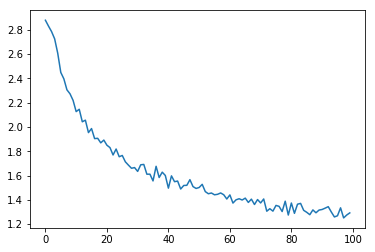

In [23]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

In [24]:
print("done")

done


Evaluating the Results
======================


confustion matrix wiki : 
https://en.wikipedia.org/wiki/Confusion_matrix

네트워크가 다른 카테고리에서 얼마나 잘 작동하는지 보려면
 각각의 언어에 confusion matrix를 만들어야 합니다.
 로우 에는 각각의 언어 컬럼에는 네트워크가 추측한 언어
 

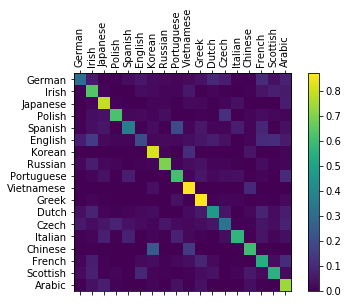

In [25]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    
    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()